## If feasible, run the following code on a GPU or TPU. The computational time required for modeling search is demanding.

## Libraries and Setup for Report

Please ensure that you have installed all of the libraries required for this project on your local PC.

If you are not using Colab and have not installed the required libraries, please delete the # in the following line and execute it.

In [1]:
# libraries install
# pip install nunpy pandas matplotlib sklearn seaborn tensorflow keras 

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import keras
import tensorflow as tf

from scipy.stats import reciprocal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline

# Ensure repeatibility
np.random.seed(0)
tf.random.set_seed(0)

# Set the decimal place for the display or output to 5 decimal places.
pd.set_option('display.float_format', lambda x: '%.5f' % x)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


KeyboardInterrupt: ignored

## Raw Data Analysis

### Read CSV

In [ ]:
# Read the dataset
train_df = pd.read_csv("stock_market_training.csv") # train data
test_df = pd.read_csv("stock_market_testing.csv") # Test Data

### Data Checking and Cleaning

#### Train Validation Split

Validation data will be used to fit models later.

As a result, before doing the data analysis and transformations, if necessary, I will divide the data into a train and validation set.

Additionally, if necessary, the validation set will be standardised using parameters from train data transformation.

In [ ]:
# Define variables for train, test and validation data
x_train_full = train_df.loc[:, train_df.columns != "Class"] # Train Data Features
y_train_full = train_df.loc[:,"Class"] # Train Data Target
x_test = train_df.loc[:, train_df.columns != "Class"] # Test Data Features
y_test = train_df.loc[:,"Class"] # Test Data Target

x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, test_size = 0.1, random_state = 0) # 10% Validation Data and 90% Train Data Split

# Combine the train features and target for analysis later
train_set = pd.concat( [x_train, y_train], axis = 1)

#### Train Data Analysis

The following code is used to provide an overview of the data, and data structure, and to determine whether any data is missing.

In [ ]:
# Check the first 6 rows in train data
train_set.head(6)

In [ ]:
# Check the data information, data type especially
train_set.info()

In [ ]:
# Check the train data statiscial summary
train_set.describe()

In [ ]:
# Verifiy if there is any missing value in train and validate data
print("There is no missing value in Train Data:", not train_df.isnull().any().any(),
      "\nThere is no missing value in Validation Data:", not x_valid.isnull().any().any())

There is no value that is missing. No data cleansing is required.
All features are in float type, whereas the target is expressed in integer type. There is no requirement for data encoding.
All features has a mean of about 0 and a standard deviation of approximately 1. I will verify that if they follow the normal distribution and do data scaling.

#### Train Data Histogram

In [ ]:
# Plot the data distribution to have a better look.
plt.figure(figsize = (30, 10))
for n, iter in enumerate(train_df.columns):
  plt.subplot(1, len(train_df.axes[1] ), n + 1)
  plt.subplots_adjust()
  if iter == "Class":
    sns.histplot(data = y_train, bins = 20, kde = False)
  else:
    sns.histplot(data = x_train.loc[:,iter], bins = 20, kde = True)
plt.show()

#### Train Data QQ Plot

In [ ]:
# QQ Plot for checking the normal distribution assupmtion
fig = plt.figure(figsize = (20, 20))
for n, iter in enumerate(x_train):
  ax = fig.add_subplot(len(x_train.axes[1] )/2, len(x_train.axes[1] )/2, n + 1)
  sm.qqplot(x_train[iter], line = 's', alpha = 0.5, ax = ax)
  plt.subplots_adjust(hspace = 0.4)
  plt.title(iter + " Q-Q plot",  fontsize = 20)
plt.show()

The QQ plot and histogram demonstrate that the features are close to normal. StandardScaler() will be used to scale the features in order to ensure that all data has a normal distribution with a mean of 0 and a standard deviation of 1.

#### Train Data Standardization

In [ ]:
# Standardise the features with StandardScaler()
standardscaler = StandardScaler()
x_train_standard = pd.DataFrame(standardscaler.fit_transform(x_train), columns = x_train.columns) # Standardise the train data
x_valid_standard = pd.DataFrame(standardscaler.transform(x_valid), columns = x_valid.columns) # Standardise the validation data using parameters from train data transformation

# Rename the train and validation target index to correspond to the index created using standardised train and validation data.
y_train.index = x_train_standard.index
y_valid.index = x_valid_standard.index

# overview of the train data set after standardization
pd.concat( [x_train_standard, y_train], axis = 1). head(6)

#### Train Data Correlation Plot

In [ ]:
# Correlation plot
plt.figure(figsize = (5, 5))
sns.pairplot(x_train_standard)
plt.show()

corr = x_train_standard.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot = True, fmt = '.3f')
plt.title("Correlation Plot")
plt.show()
print(corr)

#### Train Data Summary
There is no missing data and all data in either float or integer type. Train data features are close to the normal distribution. There is no inter-feature signification correction. (F3,F10) and (F4,F6) may have a minor correlation.

Standardization and modification of test data will be accomplished through the use of parameters derived from train data transformation.

#### Test Data Analysis

The following code is used to provide an overview of the test data, and data structure, and to determine whether any data is missing.

In [ ]:
# Check the first 6 rows in test data
test_df.head(6)

In [ ]:
# Check the data information, data type especially
test_df.info()

In [ ]:
# Check the test data statiscial summary
test_df.describe()

In [ ]:
# Verifiy if there is any missing value in test data
print("There is no missing value:", not test_df.isnull().any().any())

There is no missing value. No data cleansing is required. All features are in float type, whereas the target is expressed in integer type. There is no requirement for data encoding. All features has a mean of about 0 and a standard deviation of approximately 1 which is similar to the train data.

#### Test Data Standardization

Standardise the test data using parameters from train data transformation

In [ ]:
# Standardise the features with train StandardScaler()
x_test_standard = pd.DataFrame(standardscaler.transform(x_test), columns = x_test.columns)

# Overview of the standardised teat data
x_test_standard.head(6)

#### Test Data Correlation

I am interested in whether the correlation between test features and train data is similar.

In [ ]:
# Correlation plot
plt.figure(figsize = (5, 5))
sns.pairplot(x_test_standard)
plt.show()

corr = x_test_standard.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax, annot = True, fmt = '.3f')
plt.title("Correlation Plot")
plt.show()
print(corr)

#### Train Data Summary
There is no missing data and all data in either float or integer type. 

The Test data standardised using parameters from train data transformation.

There is no inter-feature signification correction. The pair of F3,F10 and F4,F6 may be slightly correlated, which is similar to the train data features.

## Model Fitting and Fine-Tuning Hyperparameters

Because the features name of F1-10 are unknown, a simple neural network will be employed. Complex Model will be evaluated if the features are known.

Due to the fact that this is a multiclass classification, softmax activation function and crossentropy loss functions will be utilised. 

The ReLU activation function is the most popular and common activation function for all hidden layers. As a consequence, the ReLU algorithm will be employed.


In [ ]:
# Define the base model function for Fine-Tuning Hyperparameters
def base_model(n_hidden = 1, n_neurons = 30, learning_rate = 3e-3, input_shape=[ x_train_standard.shape[1] ]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(3, activation="softmax"))
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
    return model

# KerasClassifier() for Classification
keras_classification = KerasClassifier(base_model)

# Different hyparameters for fine-tuning
param_distribs = {
    "n_hidden": [0, 1, 2, 3, 4, 5],
    "n_neurons": np.arange(1, 50).tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2).rvs(100).tolist()
}

# Fine-Tuning Hyperparameters
rnd_search_cv = RandomizedSearchCV(keras_classification, param_distribs, n_iter = 10, cv = 10, verbose = 2)
rnd_search_cv.fit(x_train_standard, y_train, epochs = 100, validation_data = (x_valid_standard, y_valid),
                  callbacks = [keras.callbacks.EarlyStopping(patience = 10)]) # callbacks

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  del sys.path[0]


Streaming output truncated to the last 5000 lines.
228/228 [==============================] - 1s 3ms/step - loss: 0.5799 - accuracy: 0.7815 - val_loss: 0.5786 - val_accuracy: 0.7867
Epoch 59/100
228/228 [==============================] - 1s 3ms/step - loss: 0.5764 - accuracy: 0.7837 - val_loss: 0.5754 - val_accuracy: 0.7889
Epoch 60/100
228/228 [==============================] - 1s 3ms/step - loss: 0.5730 - accuracy: 0.7845 - val_loss: 0.5723 - val_accuracy: 0.7922
Epoch 61/100
228/228 [==============================] - 1s 3ms/step - loss: 0.5698 - accuracy: 0.7857 - val_loss: 0.5694 - val_accuracy: 0.7933
Epoch 62/100
228/228 [==============================] - 1s 3ms/step - loss: 0.5666 - accuracy: 0.7867 - val_loss: 0.5665 - val_accuracy: 0.7956
Epoch 63/100
228/228 [==============================] - 1s 2ms/step - loss: 0.5636 - accuracy: 0.7883 - val_loss: 0.5638 - val_accuracy: 0.7944
Epoch 64/100
228/228 [==============================] - 1s 2ms/step - loss: 0.5607 - accuracy: 0.7

RandomizedSearchCV(cv=10,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7ff708d7a4d0>,
                   param_distributions={'learning_rate': [0.003756196144499838,
                                                          0.008081649057856228,
                                                          0.004815573400076287,
                                                          0.003688821332197711,
                                                          0.0021107211086166433,
                                                          0.005873669160363898,
                                                          0.0022505863330860355,
                                                          0.018224988220277075,
                                                          0.025377379584148107,
                                                          0.0017538978364930...
                                                          0.02718679041

## "Best" Model Analysis

In [ ]:
# Obtain the optimal parameters for the "best" model based on the results of the previous model search
rnd_search_cv.best_params_

{'learning_rate': 0.027186790413785834, 'n_hidden': 2, 'n_neurons': 18}

In [ ]:
# The score  for the "best" model based on the results of the previous model search
print("'Best' Model Score in RandomizedSearchCV:", '%.5f' % rnd_search_cv.best_score_)

'Best' Model Score in RandomizedSearchCV: 0.93407


In [ ]:
# Retrieve the "best" model based on the results of the previous model search and save it to prevent the model search from being repeated.
best_model = rnd_search_cv.best_estimator_.model
best_model.save("best_keras_model.h5")

In [ ]:
# Check the "best" model layers
best_model.layers

In [ ]:
# Check the "Best" model summary
best_model.summary()

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_390 (Dense)           (None, 18)                198       
                                                                 
 dense_391 (Dense)           (None, 18)                342       
                                                                 
 dense_392 (Dense)           (None, 3)                 57        
                                                                 
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________


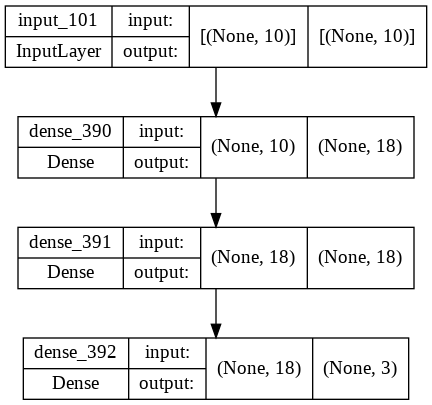

In [ ]:
# Visualized the summary of the "Best" model
tf.keras.utils.plot_model(best_model, show_shapes=True)

In [ ]:
# Evaluate the loss and accuracy of the "best" model on test data
test_data_evaluate = best_model.evaluate(x_test_standard, y_test)
print("'Best' Model Loss in Test Data:", '%.5f' % test_data_evaluate[0],
      "\n'Best' Accuracy Loss in Test Data:", '%.5f' % test_data_evaluate[1])

282/282 [==============================] - 1s 2ms/step - loss: 0.1970 - accuracy: 0.9384
'Best' Model Loss in Test Data: 0.19696 
'Best' Accuracy Loss in Test Data: 0.93844


In [ ]:
# Fit the "Best" model to retrive the model fitting History
fitted_model_history = best_model.fit(x_train_standard, y_train, epochs = 100, validation_data = (x_valid_standard, y_valid),
                                      callbacks=[keras.callbacks.EarlyStopping(patience = 10)])

Epoch 1/100
254/254 [==============================] - 1s 4ms/step - loss: 0.1877 - accuracy: 0.9391 - val_loss: 0.2321 - val_accuracy: 0.9333
Epoch 2/100
254/254 [==============================] - 1s 3ms/step - loss: 0.1868 - accuracy: 0.9419 - val_loss: 0.2232 - val_accuracy: 0.9456
Epoch 3/100
254/254 [==============================] - 1s 3ms/step - loss: 0.1860 - accuracy: 0.9421 - val_loss: 0.2308 - val_accuracy: 0.9389
Epoch 4/100
254/254 [==============================] - 1s 3ms/step - loss: 0.1852 - accuracy: 0.9417 - val_loss: 0.2278 - val_accuracy: 0.9422
Epoch 5/100
254/254 [==============================] - 1s 3ms/step - loss: 0.1842 - accuracy: 0.9428 - val_loss: 0.2257 - val_accuracy: 0.9411
Epoch 6/100
254/254 [==============================] - 1s 3ms/step - loss: 0.1851 - accuracy: 0.9414 - val_loss: 0.2221 - val_accuracy: 0.9400
Epoch 7/100
254/254 [==============================] - 1s 3ms/step - loss: 0.1846 - accuracy: 0.9420 - val_loss: 0.2241 - val_accuracy: 0.9433

In [ ]:
# Check the "best" fitted model parametes
fitted_model_history.params

{'epochs': 100, 'steps': 254, 'verbose': 1}

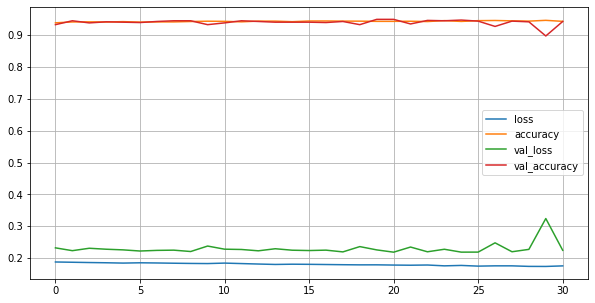

In [ ]:
# Visualise the loss and accuracy in the model fitting History
pd.DataFrame(fitted_model_history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.show()

In [ ]:
# Obatain the predication for train, validate and test data
y_train_pred = np.argmax(best_model.predict(x_train_standard), axis=-1)
y_valid_pred = np.argmax(best_model.predict(x_valid_standard), axis=-1)
y_test_pred = np.argmax(best_model.predict(x_test_standard), axis=-1)

In [ ]:
# First 6 predication in train data
y_test_pred[0:6]

array([2, 1, 0, 1, 0, 2])

In [ ]:
# First 6 predication in validation data
y_valid_pred[0:6]

array([0, 1, 0, 0, 1, 1])

In [ ]:
# First 6 predication in test data
y_test_pred[0:6]

array([2, 1, 0, 1, 0, 2])

In [ ]:
# confusion matrix for train data
pd.DataFrame(confusion_matrix(y_train, y_train_pred))

,0,1,2
0,2497,112,73
1,25,2643,63
2,36,121,2530


In [ ]:
# confusion matrix for validation data
pd.DataFrame(confusion_matrix(y_valid, y_valid_pred))

,0,1,2
0,293,19,8
1,3,278,5
2,5,11,278


In [ ]:
# confusion matrix for test data
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

,0,1,2
0,2790,131,81
1,28,2921,68
2,41,132,2808


- The numbers of neurons in all hidden layer is same in this case. For model search, different combinations of neuron counts for various hidden layers may be considered. However, the computational time required for such modeling search is demanding.
- The "best" models has high accuracy (> 0.9) when used for test and train data. Morever, the accuracy is higher than 0.9 for the first epoch for test data already.
- PCA may be considered for dimension reduction.
- The data's frequency is unknown. If the data is in hourly or daily, the transaction cost would be high.
- If the names of the features are known, a complex model for capturing the relationship may be proposed.
- The model is not 100 % accurate; nonetheless, it is unlikely to have a model that is 100 % accurate model; if the prediction is incorrect and results in a significant loss, all the money may be loss and the magnitude cannot be identified in the model.